In [1]:
%matplotlib widget
import torch
import os
import copy
if torch.cuda.is_available():
    os.environ['TORCH_CUDA_ARCH_LIST'] = f'{torch.cuda.get_device_properties(0).major}.{torch.cuda.get_device_properties(0).minor}'

import warnings
from tqdm import TqdmExperimentalWarning
warnings.filterwarnings("ignore", category=TqdmExperimentalWarning)
from tqdm.autonotebook import tqdm

import matplotlib.pyplot as plt

from sphMath.operations import sph_operation, mod
from sphMath.sampling import buildDomainDescription, sampleRegularParticles
from sphMath.modules.eos import idealGasEOS
from sphMath.modules.timestep import computeTimestep
from sphMath.schema import getSimulationScheme
from sphMath.reference.sod import buildSod_reference, sodInitialState, generateSod1D
from sphMath.modules.adaptiveSmoothingASPH import n_h_to_nH
from sphMath.reference.sod import plotSod
# from sphMath.reference.linear import buildLinearWaveSimulation, runLinearWaveTest
from sphMath.enums import *
from sphMath.reference.sod import plotSod

In [2]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
device = torch.device('cpu')
dtype = torch.float64

nx = 64
dim = 1
kernel = KernelType.CubicSpline
targetNeighbors = n_h_to_nH(8, dim)
CFL = 0.3
goalRadius = 0.8

nx = 256
rho0 = 1
E0 = 1
gamma = 1.4

scheme = SimulationScheme.CompSPH
integrationScheme = IntegrationSchemeType.rungeKutta2
viscositySwitch = ViscositySwitch.NoneSwitch
supportScheme = AdaptiveSupportScheme.NoScheme

domain = buildDomainDescription(l = 1, dim = dim, periodic = True, device = device, dtype = dtype)
domain.min = torch.tensor([0, 0], device = device, dtype = dtype)
domain.max = torch.tensor([1, 1], device = device, dtype = dtype)

simulator, SimulationSystem, solverConfig, integrator = getSimulationScheme(
     scheme, kernel, integrationScheme, 
     gamma, targetNeighbors, domain, 
     viscositySwitch=viscositySwitch, supportScheme = supportScheme)

In [3]:
import numpy as np
# Function to sample particles such that their density equals a desired PDF
def samplePDF(pdf, n = 2048, numParticles = 256, plot = False, randomSampling = False):
    x = np.linspace(-1,1,n)
    if plot:
        fig, axis = plt.subplots(1, 1, figsize=(9,6), sharex = False, sharey = False, squeeze = False)

    n = 2048
    xs = np.linspace(-1,1,n)

    if plot:
        axis[0,0].plot(xs, pdf(xs))

    normalized_pdf = lambda x: pdf(x) / np.sum(pdf(np.linspace(-1,1,n)))
    if plot:
        axis[0,0].plot(xs, normalized_pdf(xs))
        axis[0,0].axhline(0,ls= '--', color = 'black')


    xs = np.linspace(-1,1,n)
    fxs = normalized_pdf(xs)
    sampled_cdf = np.cumsum(fxs) - fxs[0]
    sampled_cdf = sampled_cdf / sampled_cdf[-1] 
    inv_cdf = lambda x : np.interp(x, sampled_cdf, np.linspace(-1,1,n))

    samples = np.random.uniform(size = numParticles)
    if not randomSampling:
        samples = np.linspace(0,1,numParticles, endpoint=False)
    sampled = inv_cdf(samples)

    return sampled

In [4]:
from sphMath.util import volumeToSupport
from sphMath.sampling import ParticleSet
domain = buildDomainDescription(l = 2, dim = dim, periodic = True, device = device, dtype = dtype)
print(domain.min, domain.max)
pdf = lambda x: 0.1 * np.sin(4*x * np.pi) + 2

tensor([-1.], dtype=torch.float64) tensor([1.], dtype=torch.float64)


In [5]:
positions = torch.tensor(samplePDF(pdf, n = 2048, numParticles = 1024, plot = False, randomSampling = False), device = device, dtype = dtype).view(-1,1)
masses = torch.ones_like(positions[:,0]) * (domain.max - domain.min)[0]/positions.shape[0] * 2
densities = torch.tensor(pdf(positions[:,0].cpu().numpy()), device = device, dtype = dtype)
supports = volumeToSupport(masses, targetNeighbors, 1)

particles_l = ParticleSet(positions, supports, masses, densities)


In [6]:

from sphMath.modules.compressible import CompressibleState
from sphMath.modules.density import computeDensity
from sphMath.neighborhood import PointCloud, DomainDescription, buildNeighborhood, filterNeighborhood, coo_to_csrsc, coo_to_csr
from sphMath.neighborhood import filterNeighborhood, filterNeighborhoodByKind, coo_to_csr, evaluateNeighborhood, SupportScheme


Pinitial = torch.zeros_like(particles_l.densities)
r = torch.linalg.norm(particles_l.positions, dim = -1)
rhoInitial = torch.ones_like(particles_l.densities)
v_initial = - torch.nn.functional.normalize(particles_l.positions, dim = -1)
# particles_l = particles_l._replace(masses = particles_l.masses * rhoInitial, densities = rhoInitial)

A_, u_, P_, c_s = idealGasEOS(A = None, u = None, P = Pinitial, rho = particles_l.densities, gamma = gamma)

internalEnergy = u_ 
kineticEnergy = torch.linalg.norm(v_initial, dim = -1) **2/ 2
totalEnergy = (internalEnergy + kineticEnergy) * particles_l.masses

simulationState = CompressibleState(
    positions = particles_l.positions,
    supports = particles_l.supports,
    masses = particles_l.masses,
    densities = particles_l.densities,        
    velocities = v_initial,
    
    internalEnergies = u_,
    totalEnergies = totalEnergy,
    entropies = A_,
    pressures = P_,
    soundspeeds = c_s,

    alphas = torch.ones_like(particles_l.densities),
    alpha0s = torch.ones_like(particles_l.densities),

    kinds = torch.zeros_like(particles_l.densities, dtype = torch.int64),
    materials= torch.zeros_like(particles_l.densities, dtype = torch.int64),
    UIDs = torch.arange(particles_l.positions.shape[0], device = device, dtype = torch.int64),
)

# neighborhood, sparseNeighborhood = buildNeighborhood(simulationState, simulationState, domain, 1.4, 'superSymmetric')
# actualNeighbors = filterNeighborhood(sparseNeighborhood)

neighborhood, neighbors = evaluateNeighborhood(simulationState, domain, kernel, verletScale = 1.0, mode = SupportScheme.SuperSymmetric, priorNeighborhood=None, computeHessian=False, computeDkDh=False, only_j = False)
simulationState.numNeighbors = coo_to_csr(filterNeighborhoodByKind(simulationState, neighbors.neighbors, which = 'noghost')).rowEntries


densities = computeDensity(simulationState, kernel, neighbors.get('noghost'), SupportScheme.Gather)
# densities = computeDensity(simulationState, simulationState, domain, solverConfig['kernel'], actualNeighbors, 'gather')
A_, u_, P_, c_s = idealGasEOS(A = None, u = None, P = Pinitial, rho = particles_l.densities, gamma = gamma)
simulationState.internalEnergies = u_

particleSystem = SimulationSystem(
        systemState = simulationState,
        domain = domain,
        neighborhoodInfo = neighborhood,
        t = 0
    )

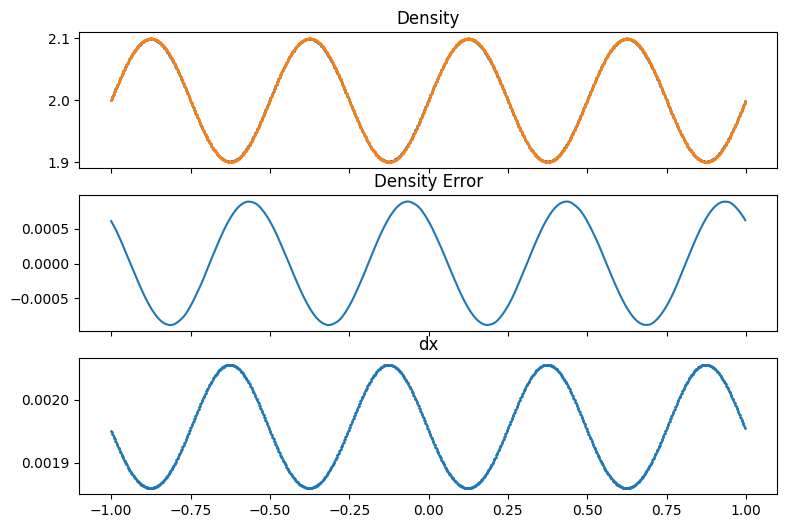

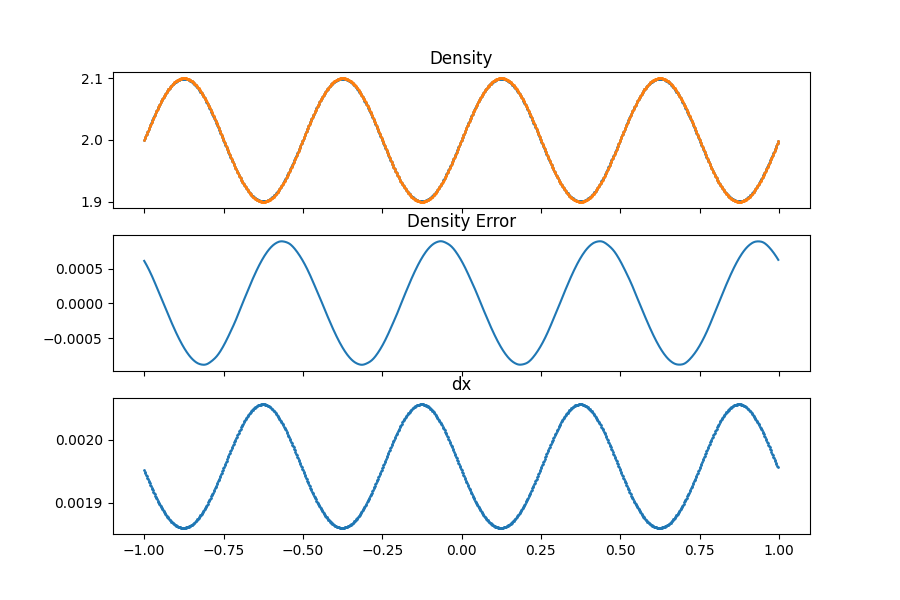

In [7]:
fig, axis = plt.subplots(3, 1, figsize=(9,6), sharex = True, sharey = False, squeeze = False)

x = particles_l.positions[:,0].cpu().numpy()
targetDensity = pdf(particles_l.positions[:,0].cpu().numpy())
currentDensity = densities.cpu().numpy()

axis[0,0].scatter(particleSystem.systemState.positions.cpu().numpy(), currentDensity, s = 1)
axis[0,0].scatter(particleSystem.systemState.positions.cpu().numpy(), targetDensity, s = 1)

axis[0,0].set_title('Density')

axis[1,0].plot(particleSystem.systemState.positions.cpu().numpy(), (currentDensity - targetDensity))
axis[1,0].set_title('Density Error')

axis[2,0].scatter(x[:-1], x[1:] - x[:-1], s = 1)
axis[2,0].set_title('dx')


display(fig )


In [22]:
regularParticles = sampleRegularParticles(positions.shape[0], domain, targetNeighbors, 0, 0)
print(regularParticles)

particleSystem = CompressibleState(
    positions = regularParticles.positions,
    supports = regularParticles.supports,
    masses = particles_l.masses,
    densities = particles_l.densities,        
    velocities = v_initial,
    
    internalEnergies = u_,
    totalEnergies = totalEnergy,
    entropies = A_,
    pressures = P_,
    soundspeeds = c_s,

    alphas = torch.ones_like(particles_l.densities),
    alpha0s = torch.ones_like(particles_l.densities),

    kinds = torch.zeros_like(particles_l.densities, dtype = torch.int64),
    materials= torch.zeros_like(particles_l.densities, dtype = torch.int64),
    UIDs = torch.arange(particles_l.positions.shape[0], device = device, dtype = torch.int64),
)


True: dxs: [tensor(0.0020, dtype=torch.float64)], ns: [tensor(1024, dtype=torch.int32)], nx: 1024
ParticleSet(positions=tensor([[-0.9990],
        [-0.9971],
        [-0.9951],
        ...,
        [ 0.9951],
        [ 0.9971],
        [ 0.9990]], dtype=torch.float64), supports=tensor([0.0156, 0.0156, 0.0156,  ..., 0.0156, 0.0156, 0.0156],
       dtype=torch.float64), masses=tensor([0.0020, 0.0020, 0.0020,  ..., 0.0020, 0.0020, 0.0020],
       dtype=torch.float64), densities=tensor([1., 1., 1.,  ..., 1., 1., 1.], dtype=torch.float64))


In [23]:
print(masses)
print(particles_l.masses)
print(regularParticles.masses)

tensor([0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
       dtype=torch.float64)
tensor([0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
       dtype=torch.float64)
tensor([0.0020, 0.0020, 0.0020,  ..., 0.0020, 0.0020, 0.0020],
       dtype=torch.float64)


In [24]:
from sphMath.neighborhood import searchNeighbors, SparseNeighborhood
pdf_torch = lambda x: 1e-1 * torch.sin(4*x * np.pi) + 2

h = volumeToSupport(masses, targetNeighbors, 1)

neighborhood, neighbors = evaluateNeighborhood(particleSystem, domain, kernel, verletScale = 1.0, mode = SupportScheme.SuperSymmetric, priorNeighborhood=None, computeHessian=False, computeDkDh=False, only_j = False)
particleSystem.numNeighbors = coo_to_csr(filterNeighborhoodByKind(particleSystem, neighbors.neighbors, which = 'noghost')).rowEntries
rhoCurrent = computeDensity(particleSystem, kernel, neighbors.get('noghost'), SupportScheme.Gather)


# particles = ParticleSet(regularParticles.positions, h, masses, regularParticles.densities)
# pointCloud = PointCloud(regularParticles.positions, regularParticles.supports)

# adjacency,_ = searchNeighbors(pointCloud, pointCloud, domain, 'gather', algorithm='compact')

# sparseNeighborhood = SparseNeighborhood(
#     row = adjacency.row,
#     col = adjacency.col,

#     numRows=pointCloud.positions.shape[0],
#     numCols=pointCloud.positions.shape[0],

#     points_a=pointCloud,
#     points_b=pointCloud,

#     domain = domain
# )

# rhoCurrent = computeDensity(particles, particles, domain, solverConfig['kernel'], sparseNeighborhood, 'gather')

print(rhoCurrent)

rhoTarget = pdf_torch(regularParticles.positions[:,0])

tensor([2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
       dtype=torch.float64)


In [25]:
print(domain)

DomainDescription(min=tensor([-1.], dtype=torch.float64), max=tensor([1.], dtype=torch.float64), periodic=tensor([True]), dim=1)


In [26]:
def computeSamplingError(currentPositions, masses, densities, targetFn, neighborhood = None):
    h = volumeToSupport(masses/2, targetNeighbors, 1)

    particleSystem.masses = masses
    particleSystem.positions = currentPositions

    neighborhood, neighbors = evaluateNeighborhood(particleSystem, domain, kernel, verletScale = 1.0, mode = SupportScheme.SuperSymmetric, priorNeighborhood=None, computeHessian=False, computeDkDh=False, only_j = False, useCheckpoint=False)
    particleSystem.numNeighbors = coo_to_csr(filterNeighborhoodByKind(particleSystem, neighbors.neighbors, which = 'noghost')).rowEntries
    rhoCurrent = computeDensity(particleSystem, kernel, neighbors.get('noghost'), SupportScheme.Gather)


    # particles = ParticleSet(currentPositions, h, masses, torch.ones_like(masses))
    # pointCloud = PointCloud(currentPositions, h)
    # with torch.no_grad():
    #     neighborhood_, sparseNeighborhood = buildNeighborhood(pointCloud, pointCloud, domain, 1.4, 'gather', priorNeighborhood=neighborhood, verbose = False)
    #     # adjacency,_ = searchNeighbors(pointCloud, pointCloud, domain, 'gather', algorithm='compact')
    #     # sparseNeighborhood = SparseNeighborhood(
    #     #     row = adjacency.row,
    #     #     col = adjacency.col,

    #     #     numRows=pointCloud.positions.shape[0],
    #     #     numCols=pointCloud.positions.shape[0],

    #     #     points_a=pointCloud,
    #     #     points_b=pointCloud,

    #     #     domain = domain
    #     # )
    #     neighborhood = neighborhood_

    # rhoCurrent = computeDensity(particles, particles, domain, solverConfig['kernel'], sparseNeighborhood, 'gather')
    rhoTarget = targetFn(particleSystem.positions[:,0])
    return rhoCurrent, rhoTarget, rhoCurrent-rhoTarget, neighborhood

In [27]:
computeSamplingError(particleSystem.positions, particleSystem.masses, particleSystem.densities, pdf_torch)

(tensor([2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
        dtype=torch.float64),
 tensor([2.0012, 2.0037, 2.0061,  ..., 1.9939, 1.9963, 1.9988],
        dtype=torch.float64),
 tensor([-0.0012, -0.0037, -0.0061,  ...,  0.0061,  0.0037,  0.0012],
        dtype=torch.float64),
 NeighborhoodInformation(points_a=PointCloud(positions=tensor([[-0.9990],
         [-0.9971],
         [-0.9951],
         ...,
         [ 0.9951],
         [ 0.9971],
         [ 0.9990]], dtype=torch.float64), supports=tensor([0.0156, 0.0156, 0.0156,  ..., 0.0156, 0.0156, 0.0156],
        dtype=torch.float64)), points_b=PointCloud(positions=tensor([[-0.9990],
         [-0.9971],
         [-0.9951],
         ...,
         [ 0.9951],
         [ 0.9971],
         [ 0.9990]], dtype=torch.float64), supports=tensor([0.0156, 0.0156, 0.0156,  ..., 0.0156, 0.0156, 0.0156],
        dtype=torch.float64)), domain=DomainDescription(min=tensor([-1.], dtype=torch.float64), max=tensor([1.], dtype=torch.float64), perio

In [28]:
pos = regularParticles.positions.clone()
pos.requires_grad = True
pos.grad = None

optimizer = torch.optim.SGD([pos], lr = 1e-2)
optimizer.zero_grad()
neighborhood = None

rhoCurrent = torch.ones_like(pos[:,0]) * 2

for i in (t:= tqdm(range(2**16))):
    optimizer.zero_grad()
    rhoCurrent, rhoTarget, error, neighborhood = computeSamplingError(pos, masses, rhoCurrent.detach(), pdf_torch, neighborhood)

    # print(rhoCurrent, rhoTarget, error**2)
    # break
    densityLoss = torch.mean(error ** 2)#**(1/2)


    idx = torch.argsort(pos[:,0])
    x_sorted = pos[idx]
    dx = x_sorted[1:] - x_sorted[:-1]
    spacing_loss = torch.mean((dx - torch.mean(dx))**2)
    loss = densityLoss + spacing_loss
    

    loss.backward()
    optimizer.step()

    t.set_description(f'rho: {densityLoss.item():.4e} dx: {spacing_loss.item():.4e}')
    # if densityLoss < 1e-4:
        # break


  0%|          | 0/65536 [00:00<?, ?it/s]

KeyboardInterrupt: 

Text(0.5, 1.0, 'dx')

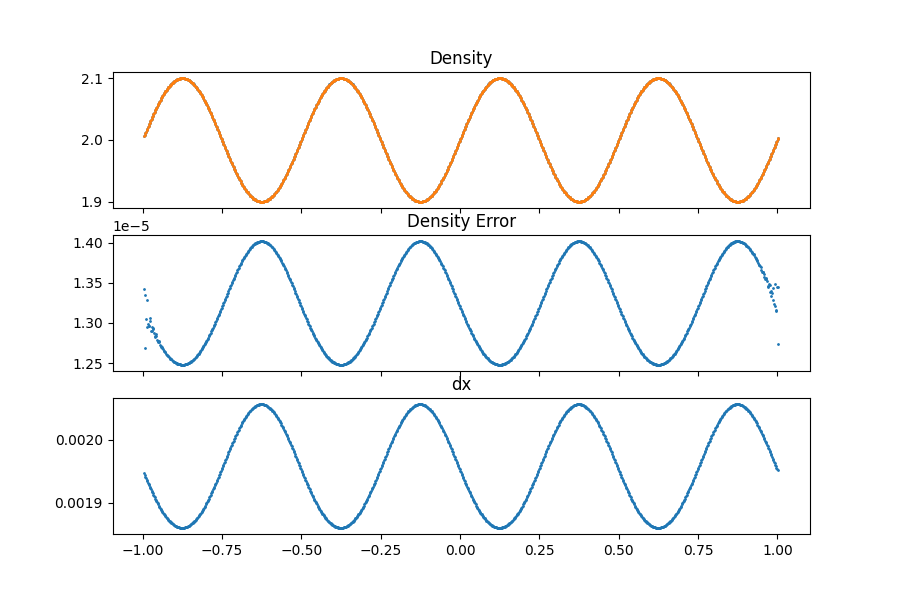

In [29]:
fig, axis = plt.subplots(3, 1, figsize=(9,6), sharex = True, sharey = False, squeeze = False)

x = pos.detach().cpu().numpy()
targetDensity = rhoTarget.detach().cpu().numpy()
currentDensity = rhoCurrent.detach().cpu().numpy()

axis[0,0].scatter(x, currentDensity, s = 1)
axis[0,0].scatter(x, targetDensity, s = 1)

axis[0,0].set_title('Density')

axis[1,0].scatter(x, (currentDensity - targetDensity), s = 1)
axis[1,0].set_title('Density Error')


idx = torch.argsort(pos[:,0].detach()).cpu().numpy()
# print(idx)
x_sorted = x[idx]
dx = x_sorted[1:] - x_sorted[:-1]
# print(dx)

axis[2,0].scatter(x_sorted[:-1], dx, s = 1)
axis[2,0].set_title('dx')


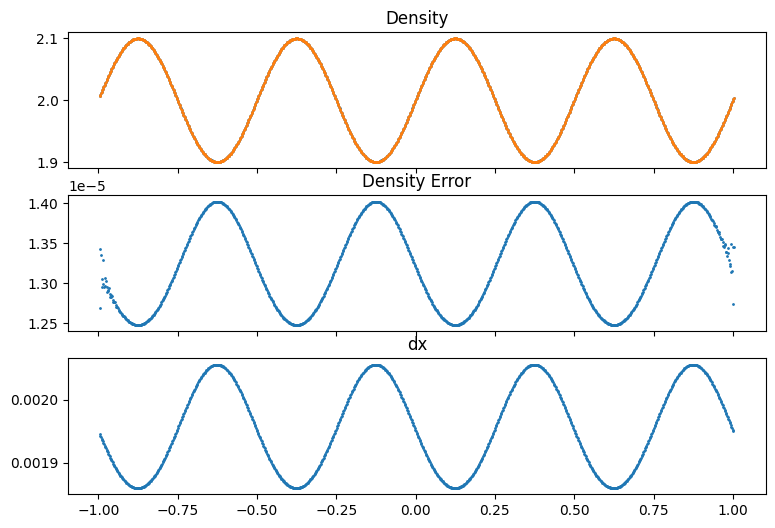

In [30]:
display(fig)